In [11]:
# custom analysis tools
from analysis.scan import scan
from analysis.tools import extract_species
from analysis.tools import muon_filter
from analysis.tools import muon_filter_by_parts

# useful python libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.optimize import curve_fit
import pandas as pd
from prettytable import PrettyTable

plt.rcParams['figure.figsize'] = 26, 10
plt.style.use('ggplot')
s = 45
alpha_single = 0.6
left = 1; right = 799

In [12]:
STUDY = 'master_neutrons'

# Get the current directory where the Jupyter Notebook is located

current_directory = get_ipython().run_line_magic('pwd', '')

# Extract the local path to 3CS folder
local_path        = current_directory.split('repo_note3cs')[0]

# Define path to study within data3cs folder
path_to_study     = f'repo_data3cs/data3cs/studies/{STUDY}'

# Final path
path              = f'{local_path}{path_to_study}'

In [13]:
# Irradiation group
LiF_irrad                = extract_species(path, 'LiF', ext='irrad') 
LiF_irrad_samples = ['LiF_B1_131', 'LiF_B2_145', 'LiF_B2_157', 'LiF_B2_158']

BaF_irrad                = extract_species(path, 'BaF', ext='irrad') 
BaF_irrad_samples = ['BaF_B2_181','BaF_B2_183', 'BaF_B2_185', 'BaF_B2_192']

Qz_irrad                   = extract_species(path, 'Qz', ext='irrad') 
Qz_irrad_samples    = ['Qz_B2_063', 'Qz_B2_069', 'Qz_B2_072']

SP_irrad                   = extract_species(path, 'SP', ext='irrad') 
SP_irrad_samples     = ['SP4500', 'SP4501', 'SP4502', 'SP4503']

# Control group
LiF_ctrl                     = extract_species(path, 'LiF', ext='ctrl') 
LiF_ctrl_samples      = ['LiF_B1_130', 'LiF_B2_143', 'LiF_B2_155']

BaF_ctrl                     = extract_species(path, 'BaF', ext='ctrl') 
BaF_ctrl_samples     = ['BaF_B2_182','BaF_B2_188', 'BaF_B2_193']

Qz_ctrl                        = extract_species(path, 'Qz', ext='ctrl') 
Qz_ctrl_samples         = ['Qz_B2_064',  'Qz_B2_071']

SP_ctrl                        = extract_species(path, 'SP', ext='ctrl') 
SP_ctrl_samples         = ['SP4504']

In [14]:
# Extarct background function

def cut_array(input, cuts = 1):
    left = cuts
    right = len(input) - 1
    return input[left:right]

def get_bkgs(group, samples, wl, type = 'A', size = 798):
    bkg_array = np.zeros(size)
    colls           = len(group)
    count         = 0
    for coll in range(1,colls+1):
        for sample in samples:
            df = group[f'coll{coll}'][f'{sample}_{type}'].df
            y   = np.array(df.loc[(wl, '0', '15.0sec', 'bg_0')]['count'])[left:right]
            y_filt = muon_filter_by_parts(y, bins = 5)
            bkg_array = bkg_array  + y_filt
            count+=1

    x = np.array(df.loc[(wl, '0', '15.0sec', 'bg_0')]['em_wl'])[left:right]
    bkg_array = bkg_array / count

    return x, bkg_array

def add_spectra(group, samples, wl, centre, type, colls):
    spectra_array = []
    count                = 0

    if type == 'bg':
        its = 1
    elif type == 'sp':
        its = 4

    for coll in colls:
        for sample in samples:
            df = group[f'coll{coll}'][f'{sample}_{centre}'].df
            for it in range(its):
                y   = np.array(df.loc[(wl, '0', '15.0sec', f'{type}_{it}')]['count'])
                y   = cut_array(y)
                y_filtered = muon_filter_by_parts(y)
                spectra_array.append(y_filtered)
                count+=1

    x = np.array(df.loc[(wl, '0', '15.0sec', f'{type}_{it}')]['em_wl'])
    x = cut_array(x)

    arrays_np = np.array(spectra_array)
    nanmean = np.nanmean(arrays_np, axis=0)
    
    return x, nanmean, count

def Gaussian(x, A, m, s, offset = 0):
    return A * np.exp( -0.5 * ((x - m)**2) / (s**2) ) + offset

def offset_4Gaussians(x, A1, A2, A3, A4, m1, m2, m3, m4, s1, s2, s3, s4, offset):
    a = Gaussian(x, A1, m1, s1)
    b = Gaussian(x, A2, m2, s2)
    c = Gaussian(x, A3, m3, s3)
    d = Gaussian(x, A4, m4, s4)

    return a+b+c+d+offset

def offset_5Gaussians(x, A1, A2, A3, A4, A5, m1, m2, m3, m4, m5, s1, s2, s3, s4, s5, offset):
    a = Gaussian(x, A1, m1, s1)
    b = Gaussian(x, A2, m2, s2)
    c = Gaussian(x, A3, m3, s3)
    d = Gaussian(x, A4, m4, s4)
    e = Gaussian(x, A5, m5, s5)

    return a+b+c+d+e+offset

---

## Backgorund model for 250/260 Window

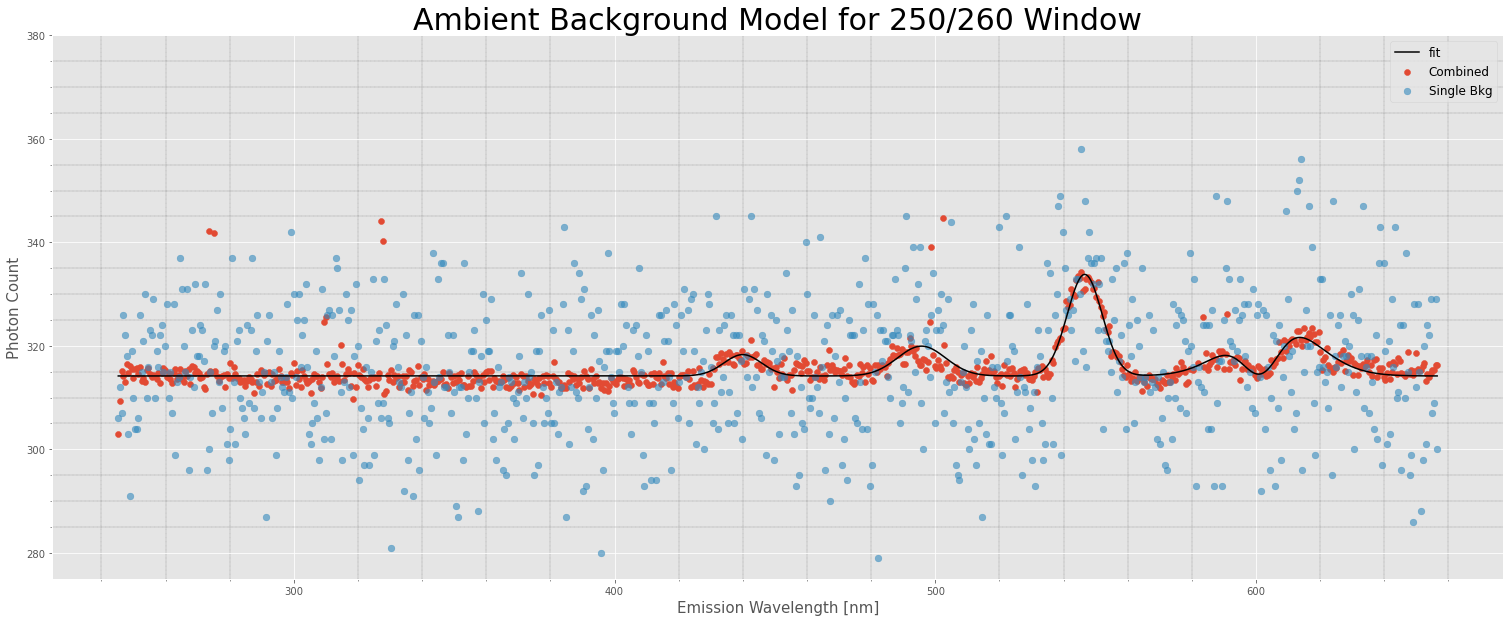

+----------+----------------+-----------------+----------------+
| Gaussian |       A        |        m        |       s        |
+----------+----------------+-----------------+----------------+
|    1     |  4.12 (0.792)  | 439.936 (1.298) | 5.898 (1.327)  |
|    2     | 5.758 (0.702)  | 495.693 (1.045) | 7.487 (1.074)  |
|    3     | 19.622 (0.82)  | 546.573 (0.261) | 5.442 (0.266)  |
|    4     | -9.698 (3.144) | 601.756 (0.816) | -5.821 (1.307) |
|    5     | 10.564 (3.225) | 605.422 (1.507) | 12.986 (1.593) |
+----------+----------------+-----------------+----------------+
Offset = 314.181 (0.134)
Mean = 0.778, Std = 11.918
Model Params: [  4.11988944   5.757796    19.6223119   -9.69799666  10.5641773
 439.936038   495.69336435 546.57268588 601.7559566  605.42206786
   5.89833756   7.48714367   5.44249217  -5.82091785  12.98600865
 314.1805248 ]


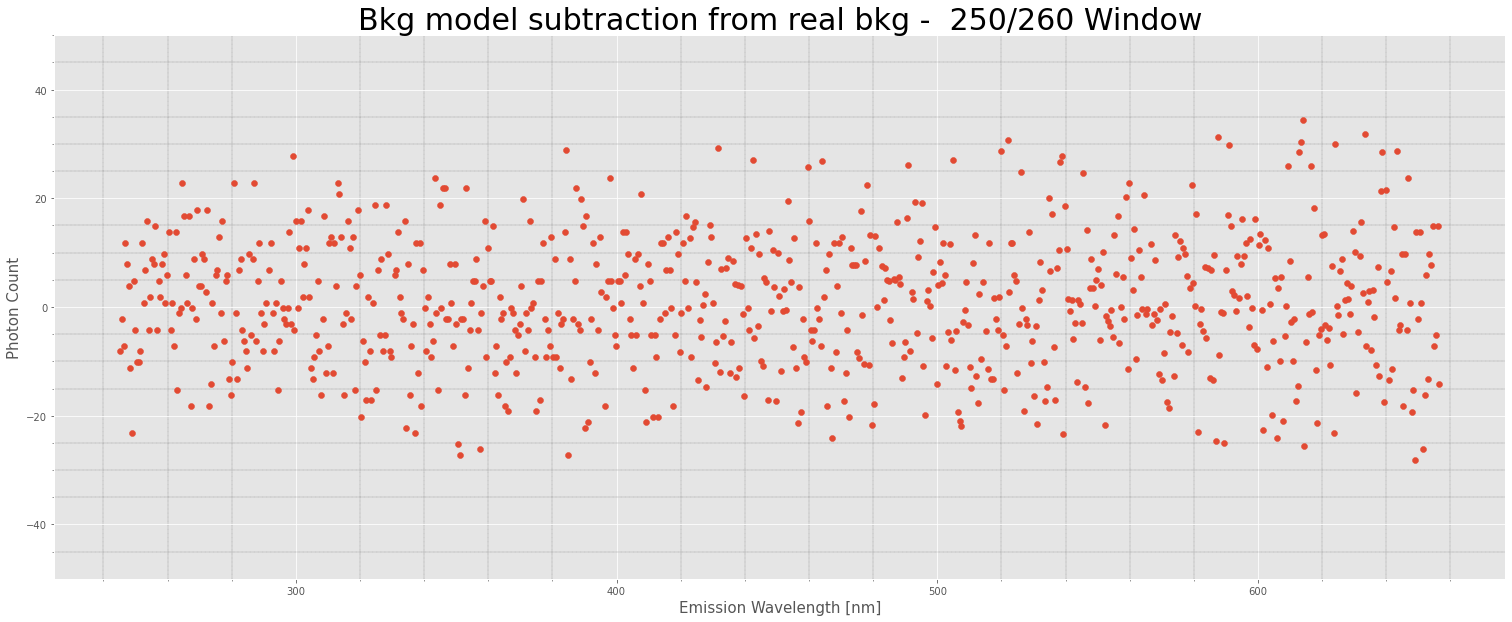

In [15]:
x, Y_irrad, c_baf_irrad = add_spectra(BaF_irrad, BaF_irrad_samples, '250', 'A', 'bg',  ['1', '2', '3', '4', '5', '6'])
_, Y_ctrl, c_baf_ctrl = add_spectra(BaF_ctrl, BaF_ctrl_samples, '250', 'A', 'bg',  ['1', '2', '3', '4', '5', '6'])
tot_baf = c_baf_irrad + c_baf_ctrl
Y_BaF_250 = np.add( (Y_irrad * c_baf_irrad/tot_baf) , (Y_ctrl * c_baf_ctrl/tot_baf) )

x, Y_irrad, c_qz_irrad = add_spectra(Qz_irrad, Qz_irrad_samples, '250', 'A', 'bg',  ['1', '2', '3', '4', '5', '6'])
_, Y_ctrl, c_qz_ctrl = add_spectra(Qz_ctrl, Qz_ctrl_samples, '250', 'A', 'bg',  ['1', '2', '3', '4', '5', '6'])
tot_qz = c_qz_irrad + c_qz_ctrl
Y_Qz_250 = np.add( (Y_irrad * c_qz_irrad/tot_qz) , (Y_ctrl * c_qz_ctrl/tot_qz) )

x, Y_irrad, c_sp_irrad = add_spectra(SP_irrad, SP_irrad_samples, '250', 'A', 'bg',  ['1', '2', '3', '4', '5', '6'])
_, Y_ctrl, c_sp_ctrl = add_spectra(SP_ctrl, SP_ctrl_samples, '250', 'A', 'bg',  ['1', '2', '3', '4', '5', '6'])
tot_sp = c_sp_irrad + c_sp_ctrl
Y_SP_250 = np.add( (Y_irrad * c_sp_irrad/tot_sp) , (Y_ctrl * c_sp_ctrl/tot_sp) )

TOT = tot_baf + tot_qz + tot_sp

Y = (Y_BaF_250 * (tot_baf/ TOT)) + (Y_Qz_250 * (tot_qz/TOT)) + (Y_SP_250 * (tot_sp/TOT))

nan_index =[646, 648, 649, 651, 652]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

guess = [10,10,20,10, 10,  450,500, 550, 600 ,630, 10,10,10, 5,10, 320]
popt, pcov = curve_fit(offset_5Gaussians, x_free, Y_free, p0 = guess)
plt.plot(x_free, offset_5Gaussians(x_free, *popt), color='black', label = 'fit')

plt.scatter(x_free,Y_free, label = 'Combined')

df = SP_irrad['coll2']['SP4502_A'].df
y   = np.array(df.loc[('250', '0', '15.0sec', 'bg_0')]['count'])[left:right]

plt.scatter(x,y, label = 'Single Bkg', s = s, alpha = alpha_single)

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Ambient Background Model for 250/260 Window', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.ylim(275, 380)
plt.show();

p_errors = np.sqrt(np.diag(pcov))

As = [np.round(popt[0:5], 3),  np.round(p_errors[0:5] , 3)]
ms = [np.round(popt[5:10], 3),  np.round(p_errors[5:10] , 3)]
ss = [np.round(popt[10:15], 3),  np.round(p_errors[10:15] , 3)]
off = [np.round(popt[15], 3),  np.round(p_errors[15] , 3)]

# Create a PrettyTable object
table = PrettyTable()

# Define the columns
table.field_names = ["Gaussian", "A", "m", "s"]

# Add data to the table
table.add_row([1, f'{As[0][0]} ({As[1][0]})', f'{ms[0][0]} ({ms[1][0]})', f'{ss[0][0]} ({ss[1][0]})'])
table.add_row([2, f'{As[0][1]} ({As[1][1]})', f'{ms[0][1]} ({ms[1][1]})', f'{ss[0][1]} ({ss[1][1]})'])
table.add_row([3, f'{As[0][2]} ({As[1][2]})', f'{ms[0][2]} ({ms[1][2]})', f'{ss[0][2]} ({ss[1][2]})'])
table.add_row([4, f'{As[0][3]} ({As[1][3]})',f'{ms[0][3]} ({ms[1][3]})', f'{ss[0][3]} ({ss[1][3]})'])
table.add_row([5, f'{As[0][4]} ({As[1][4]})', f'{ms[0][4]} ({ms[1][4]})', f'{ss[0][4]} ({ss[1][4]})'])

# Print the table
print(table)
print(f'Offset = {off[0]} ({off[1]})')

# test by subtracting bkg model from real data

bkg_model = offset_5Gaussians(x, *popt)
y_sub            = np.subtract(y, bkg_model)
y_sub            = muon_filter_by_parts(y_sub, bins = 15)
plt.scatter(x, y_sub)

mean = np.round(np.nanmean(y_sub),3)
std = np.round(np.nanstd(y_sub),3)
print(f'Mean = {mean}, Std = {std}')

plt.ylim(-50, 50)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Bkg model subtraction from real bkg -  250/260 Window', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
print(f'Model Params: {popt}')

## Backgorund model for 435 Window

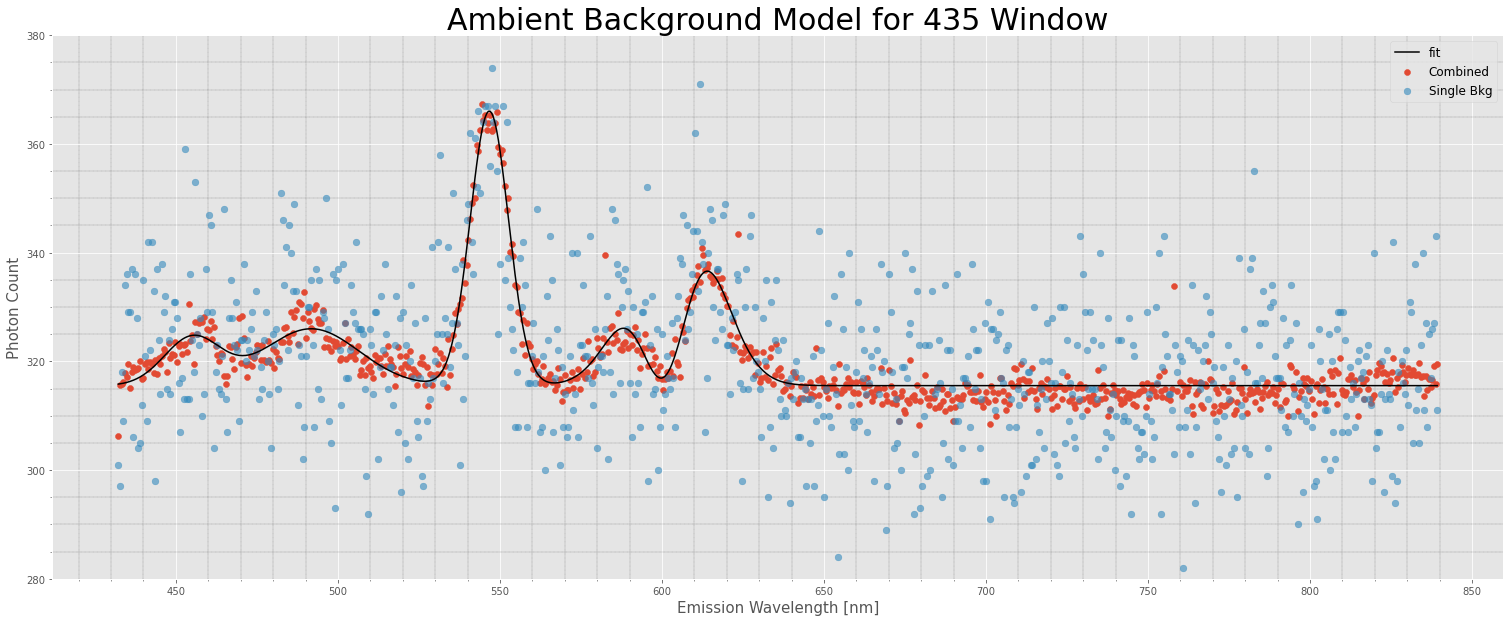

+----------+------------------+-----------------+----------------+
| Gaussian |        A         |        m        |       s        |
+----------+------------------+-----------------+----------------+
|    1     |  8.766 (1.746)   | 455.029 (2.472) |  8.687 (2.42)  |
|    2     |  10.46 (1.359)   | 491.743 (2.736) | 14.791 (3.042) |
|    3     |  50.51 (2.031)   | 546.721 (0.272) | 5.909 (0.278)  |
|    4     | -48.753 (53.023) | 601.357 (1.078) | 7.667 (2.157)  |
|    5     |  51.51 (53.516)  |  603.338 (1.68) | 11.524 (2.317) |
+----------+------------------+-----------------+----------------+
Offset = 315.536 (0.361)
Mean = 0.507, Std = 11.957
Model Params: [  8.76609133  10.46031313  50.51038021 -48.75345784  51.51011464
 455.02892594 491.74321717 546.72075592 601.35695421 603.33838787
   8.68728288  14.79082917   5.90917478   7.66695692  11.52427167
 315.53588353]


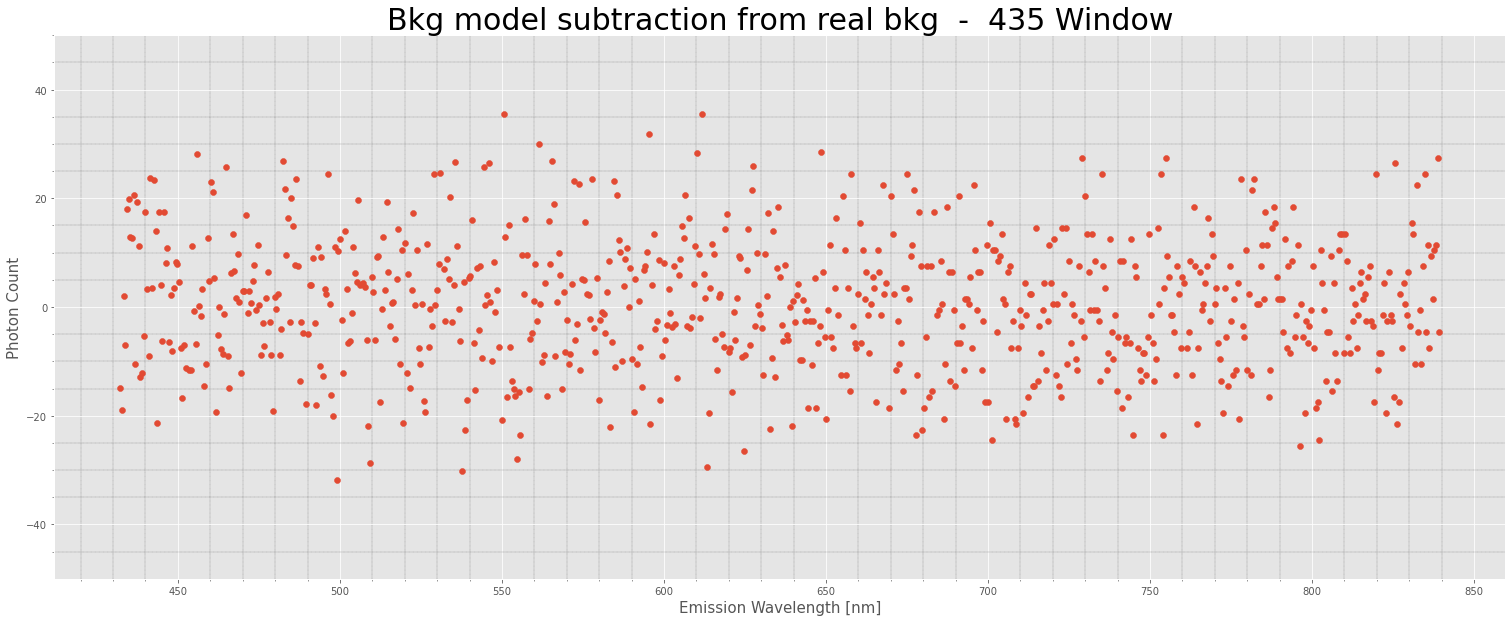

In [16]:
x, Y_irrad, c_lif_irrad = add_spectra(LiF_irrad, LiF_irrad_samples, '435', 'B', 'bg',  ['1', '2', '3', '4', '5', '6'])
_, Y_ctrl, c_lif_ctrl = add_spectra(LiF_ctrl, LiF_ctrl_samples, '435', 'B', 'bg',  ['1', '2', '3', '4', '5', '6'])
tot_lif = c_lif_irrad + c_lif_ctrl
Y = np.add( (Y_irrad * c_lif_irrad/tot_lif) , (Y_ctrl * c_lif_ctrl/tot_lif) )

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

guess = [10,10,20,10, 10,  450,500, 550, 600 ,630, 10,10,10, 5,10, 320]
popt, pcov = curve_fit(offset_5Gaussians, x_free, Y_free, p0 = guess)
plt.plot(x_free, offset_5Gaussians(x_free, *popt), color='black', label = 'fit')

plt.scatter(x_free,Y_free, label = 'Combined')

df = LiF_irrad['coll3']['LiF_B2_157_B'].df
y   = np.array(df.loc[('435', '0', '15.0sec', 'bg_0')]['count'])[left:right]

plt.scatter(x,y, label = 'Single Bkg', s = s, alpha = alpha_single)

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Ambient Background Model for 435 Window', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.ylim(280, 380)
plt.show();

p_errors = np.sqrt(np.diag(pcov))

As = [np.round(popt[0:5], 3),  np.round(p_errors[0:5] , 3)]
ms = [np.round(popt[5:10], 3),  np.round(p_errors[5:10] , 3)]
ss = [np.round(popt[10:15], 3),  np.round(p_errors[10:15] , 3)]
off = [np.round(popt[15], 3),  np.round(p_errors[15] , 3)]

# Create a PrettyTable object
table = PrettyTable()

# Define the columns
table.field_names = ["Gaussian", "A", "m", "s"]

# Add data to the table
table.add_row([1, f'{As[0][0]} ({As[1][0]})', f'{ms[0][0]} ({ms[1][0]})', f'{ss[0][0]} ({ss[1][0]})'])
table.add_row([2, f'{As[0][1]} ({As[1][1]})', f'{ms[0][1]} ({ms[1][1]})', f'{ss[0][1]} ({ss[1][1]})'])
table.add_row([3, f'{As[0][2]} ({As[1][2]})', f'{ms[0][2]} ({ms[1][2]})', f'{ss[0][2]} ({ss[1][2]})'])
table.add_row([4, f'{As[0][3]} ({As[1][3]})',f'{ms[0][3]} ({ms[1][3]})', f'{ss[0][3]} ({ss[1][3]})'])
table.add_row([5, f'{As[0][4]} ({As[1][4]})', f'{ms[0][4]} ({ms[1][4]})', f'{ss[0][4]} ({ss[1][4]})'])

# Print the table
print(table)
print(f'Offset = {off[0]} ({off[1]})')

# test by subtracting bkg model from real data

bkg_model = offset_5Gaussians(x, *popt)
y_sub            = np.subtract(y, bkg_model)
y_sub            = muon_filter_by_parts(y_sub, bins = 15)
plt.scatter(x, y_sub)

mean = np.round(np.nanmean(y_sub),3)
std = np.round(np.nanstd(y_sub),3)
print(f'Mean = {mean}, Std = {std}')

plt.ylim(-50, 50)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Bkg model subtraction from real bkg  -  435 Window', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
print(f'Model Params: {popt}')

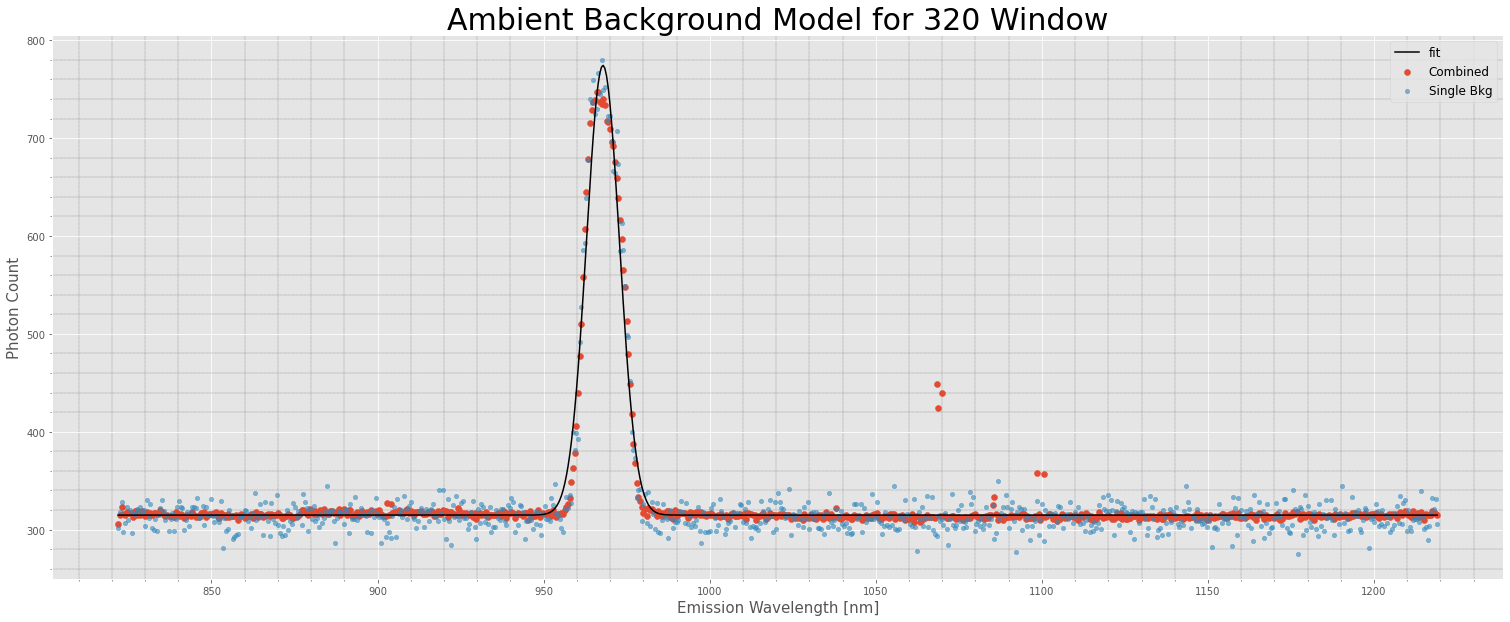

+----------+-----------------+-----------------+---------------+
| Gaussian |        A        |        m        |       s       |
+----------+-----------------+-----------------+---------------+
|    1     | 459.593 (3.375) | 967.849 (0.042) | 4.988 (0.043) |
+----------+-----------------+-----------------+---------------+
Offset = 314.845 (0.422)
Mean = -2.265, Std = 14.223
Model Params: [459.59349593 967.84928263   4.98752523 314.84527068]


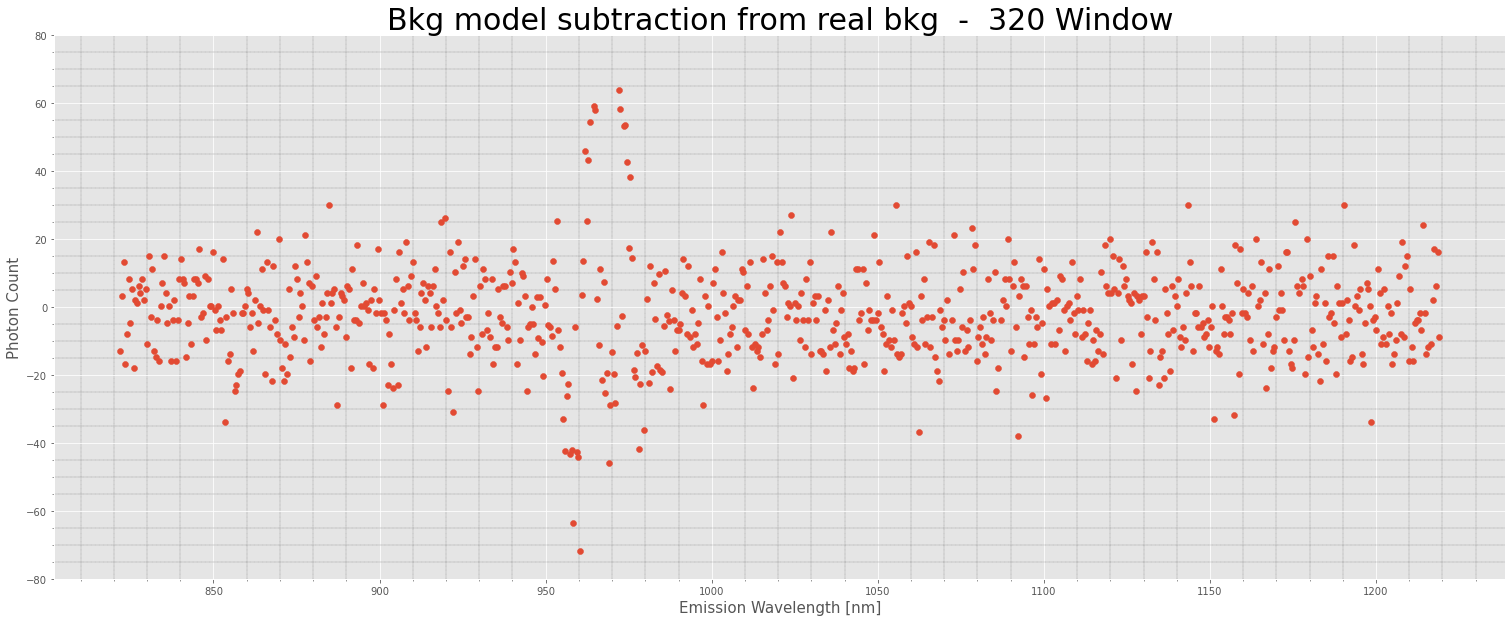

In [17]:
x, Y_irrad, c_baf_irrad = add_spectra(BaF_irrad, BaF_irrad_samples, '320', 'B', 'bg',  ['1', '2', '3', '4', '5', '6'])
_, Y_ctrl, c_baf_ctrl = add_spectra(BaF_ctrl, BaF_ctrl_samples, '320', 'B', 'bg',  ['1', '2', '3', '4', '5', '6'])
tot_baf = c_baf_irrad + c_baf_ctrl
Y = np.add( (Y_irrad * c_baf_irrad/tot_baf) , (Y_ctrl * c_baf_ctrl/tot_baf) )

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

guess = [100, 950, 10, 300]
popt, pcov = curve_fit(Gaussian, x_free, Y_free, p0 = guess)
plt.plot(x_free, Gaussian(x_free, *popt), color='black', label = 'fit')

plt.scatter(x_free,Y_free, label = 'Combined')

df = BaF_irrad['coll1']['BaF_B2_181_B'].df
y   = np.array(df.loc[('320', '0', '15.0sec', 'bg_0')]['count'])[left:right]

plt.scatter(x,y, label = 'Single Bkg', s = 20, alpha = alpha_single)

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Ambient Background Model for 320 Window', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();

p_errors = np.sqrt(np.diag(pcov))

A = [np.round(popt[0],3) , np.round(p_errors[0],3)]
m = [np.round(popt[1],3), np.round(p_errors[1],3)]
s = [np.round(popt[2], 3), np.round(p_errors[2],3)]
off = [np.round(popt[3], 3) , np.round(p_errors[3],3)]

# Create a PrettyTable object
table = PrettyTable()

# Define the columns
table.field_names = ["Gaussian", "A", "m", "s"]

# Add data to the table
table.add_row([1, f'{A[0]} ({A[1]})', f'{m[0]} ({m[1]})', f'{s[0]} ({s[1]})'])

# Print the table
print(table)
print(f'Offset = {off[0]} ({off[1]})')


# test by subtracting bkg model from real data

bkg_model = Gaussian(x, *popt)
y_sub            = np.subtract(y, bkg_model)
y_sub            = muon_filter_by_parts(y_sub, bins = 15)
plt.scatter(x, y_sub)

mean = np.round(np.nanmean(y_sub),3)
std = np.round(np.nanstd(y_sub),3)
print(f'Mean = {mean}, Std = {std}')

plt.ylim(-80, 80)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Bkg model subtraction from real bkg  -  320 Window', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
print(f'Model Params: {popt}')